In [1]:
##nodejs:  https://docs.aws.amazon.com/sdk-for-javascript/v2/developer-guide/setting-up-node-on-ec2-instance.html

# !pip install "jupyterlab>=3" "ipywidgets>=7.6"
# !pip install jupyter-dash
# !jupyter lab build

# !pip install snowflake --user
# !pip install snowflake-connector-python --user
# !pip install category_encoders
# !pip install xgboost
# !pip install fuzzywuzzy --user
# !pip install lightgbm --user

import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
from utils import *
import snowflake.connector
from datetime import timedelta

from category_encoders import OneHotEncoder
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as r2_score
import sklearn.model_selection
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning


## Functions

In [2]:

def _encode(df, categoricals):
    """
    perform category encoding on the data
    :param df: dataframe to be encoded
    :param categoricals: list of name of categorical columns
    :return ohe, x_ohe: OHE object and OHE-encoded data
    """

    ohe = OneHotEncoder(cols=categoricals, 
                        handle_unknown='return_nan',
                       handle_missing='return_nan',
                       use_cat_names=True) 
    x_ohe = ohe.fit_transform(df)
    return ohe, x_ohe


def train_lr(df_train, features_cat, features_cont, target):
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)
  
    # fit
    lm = LinearRegression()
    model = lm.fit(x_ohe, y_train)
       
    return model, ohe

def predict_lr(df_test, model, ohe, features_cat, features_cont, target, postfix):    
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    y_pred = model.predict(x_ohe_test)

    df_pred = df_test[['title_name', 'title_id',] + features_cat + features_cont + ['first_views']]
    df_pred['first_views_{}'.format(postfix)] = np.exp(pred)
  
    rmse = np.sqrt(MSE(np.exp(y_test), np.exp(pred)))
    mae = MAE(np.exp(y_test), np.exp(pred))
    print("Aggergate error : % f" %(np.exp(pred).sum()-np.exp(y_test).sum()))
    print("RMSE : % f" %(rmse))
    print("MAE : % f" %(mae)) 
    
    return df_pred

def train_xgb(df_train, features_cat, features_cont, target, param):
  
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)
    dm_train = xgb.DMatrix(x_ohe, label=y_train)
    
    ## train 
    model = xgb.train(params = param, dtrain = dm_train, num_boost_round = 10)
    
    return model, ohe

def predict_xgb(df_test, model, ohe, features_cat, features_cont, target, postfix):
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    dm_test = xgb.DMatrix(x_ohe_test, label=y_test)
    pred = model.predict(dm_test)
    
    df_pred = df_test[list(set(['title_name', 'title_id','category','season_number', 'effective_start_date'] + features_cat + features_cont + ['first_views']))]
    df_pred['first_views_log_{}'.format(postfix)] = pred

    return df_pred



def train_lgbm(df_train, features_cat, features_cont, target, param):       
    x_train = df_train[features_cat + features_cont]
    y_train = df_train[target]
    ohe, x_ohe = _encode(x_train, features_cat)

    x_train = lightgbm.Dataset(x_ohe, label=y_train)
    model = lightgbm.train(param, x_train, verbose_eval = -1)

    return model, ohe


def predict_lgbm(df_test, model, ohe, features_cat, features_cont, target, postfix):
    x_test = df_test[features_cat + features_cont]
    y_test = df_test[target]

    ## predict       
    x_ohe_test = ohe.transform(x_test)
    pred = model.predict(x_ohe_test)

    df_pred = df_test[['title_name', 'title_id',] + features_cat + features_cont + ['first_views']]
    df_pred['first_views_log_{}'.format(postfix)] = pred
    df_pred.head()

    return df_pred


def evaluate_pred(df_eval, pred_list):
    print('')
    print('_____________________________________________________________')
    actuals_mean=df_eval['first_views'].mean()
    actuals_sum=df_eval['first_views'].sum()
    print(f'Aggregate actuals: Count: {df_eval.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
    for i in pred_list:
        mae = MAE(df_eval['first_views'], df_eval[f'first_views_{i}'])
        actuals=df_eval['first_views'].sum()
        pred=df_eval[f'first_views_{i}'].sum()
        print(f'{i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals)/actuals*100:.0f}%; pred: {pred:.0f}; ')



## Features 

target = 'first_views_log'

features_cat=[
    'start_year',
    'tier',
    'content_category',
    'program_type',
    'category'
]

features_cont=[
#     'season_number',
    'ref_tot',
#     'ref_ref_tot'
]


### Model parameters 
param_xgb = {"booster":"gbtree",
             "objective":"reg:squarederror",
            "gamma":1}


param_lgbm = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}



# Prediction

#### Get train/pred data

In [3]:
date_eval_end = '2021-09-01'

df_raw=pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_actual_1025.csv')
df_raw= df_raw.copy()
df_raw['effective_start_date'] = pd.to_datetime(df_raw['effective_start_date'])
df_raw['start_year'] = pd.to_datetime(df_raw['effective_start_date']).dt.year
df_raw['start_month'] = pd.to_datetime(df_raw['effective_start_date']).dt.month
df_raw['start_year_month'] = df_raw['effective_start_date'].dt.strftime('%Y-%m')
df_raw['start_quarter'] = df_raw['effective_start_date'].dt.quarter

df_raw = df_raw[(df_raw['effective_start_date']<=date_eval_end) & (df_raw.title_name!='Dune')]

grpby_title= ['tier','content_category','category','title_name', 'title_id','season_number',
        'program_type','effective_start_date', 'start_year', 'start_month', 'start_year_month', 'start_quarter']
df = df_raw[['first_views','premiering_hours_runtime'] + grpby_title].groupby(by=grpby_title).sum().reset_index()
print(df.shape)
print('# title: ', df.title_name.nunique())
df = df[df['first_views']!=0]
print(df.shape)
df['first_views_log'] = np.log(df['first_views'])


## add imdb features 
df_imdb = pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/imdb_features_engineered.csv')
print(df_imdb.columns)

col = ['title_id', 'asset_title_long', 'imdb_id', 'genres', 'title_type',
       'ref_follows', 'ref_remake_of', 'ref_spin_off_from', 'ref_version_of',
      'ref_ref_featured_in','ref_ref_spoofed_in']
df = df.merge(df_imdb[col], how='left', on=['title_id'])
df['ref_tot'] = df[['ref_follows','ref_remake_of','ref_spin_off_from','ref_version_of']].sum(axis=1)
df['ref_ref_tot'] = df[['ref_ref_featured_in','ref_ref_spoofed_in']].sum(axis=1)

## Clean data and make a copy for evaluation
df = df.fillna(0)
df.head(2)
print(df.shape)
print('# title: ', df.title_name.nunique())
print(df.columns)
df=df.drop_duplicates(subset=['title_id','tier','category','season_number'],keep='first')
print(df.shape)

df_actual = df.copy()

## Adjust tier feature for train & pred 
df.loc[(df['category']=='Popcorn') & (df['tier']==1), ['tier']] = 0
df.loc[(df['category']=='Popcorn') & (df['tier']==2), ['tier']] = 1

df_train = df.copy()

(317, 14)
# title:  268
(317, 14)
Index(['Unnamed: 0', 'tier', 'content_category', 'category', 'title_name',
       'title_id', 'season_number', 'program_type', 'first_views',
       'title_type', 'imdb_id', 'asset_title_long', 'genres', 'ref_follows',
       'ref_spin_off_from', 'ref_remake_of', 'ref_version_of',
       'ref_ref_featured_in', 'ref_ref_spoofed_in'],
      dtype='object')
(623, 27)
# title:  268
Index(['tier', 'content_category', 'category', 'title_name', 'title_id',
       'season_number', 'program_type', 'effective_start_date', 'start_year',
       'start_month', 'start_year_month', 'start_quarter', 'first_views',
       'premiering_hours_runtime', 'first_views_log', 'asset_title_long',
       'imdb_id', 'genres', 'title_type', 'ref_follows', 'ref_remake_of',
       'ref_spin_off_from', 'ref_version_of', 'ref_ref_featured_in',
       'ref_ref_spoofed_in', 'ref_tot', 'ref_ref_tot'],
      dtype='object')
(317, 27)


#### Train & predict

In [4]:
date_eval_end = '2021-09-01'
list_date_pred = ['2021-01-01','2021-02-01','2021-03-01',
                  '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']

In [5]:
## Get decay curve 
def get_decay_data_title(df_plt, grpby):
    df_plt = df_plt[grpby + ['days_since_premiere','first_views']].sort_values(by=grpby+['days_since_premiere'])
    df_plt['first_views_sum'] = df_plt.groupby(grpby)['first_views'].transform('sum')
    df_plt['first_views_cumsum'] = df_plt.groupby(by=grpby)['first_views'].cumsum()
    df_plt['first_views_cumpct'] = df_plt['first_views_cumsum'] / df_plt['first_views_sum']
    df_plt.reset_index(inplace=True)
    return df_plt

def get_decay_data(df_plt, grpby):
    df_plt = df_plt[grpby + ['title_id','days_since_premiere','first_views_cumpct']].sort_values(by=grpby+['days_since_premiere'])
    df_plt = df_plt.groupby(by=grpby + ['days_since_premiere']).agg({'first_views_cumpct':'median','title_id':'nunique'})
    df_plt['first_views_pct'] = df_plt.groupby(grpby)['first_views_cumpct'].diff()
    df_plt = df_plt.rename(columns={'title_id':'title_count_training'})
    df_plt.reset_index(inplace=True)
    df_plt.loc[(df_plt['first_views_pct'].isnull()) & (df_plt.days_since_premiere==0),'first_views_pct'] = df_plt['first_views_cumpct']
    df_plt['days_since_premiere'] = df_plt['days_since_premiere'].astype(int)
    return df_plt

def get_quarter_first_views(df_in, grpby_title, request_date_col, first_view_col, postfix):
    grpby_title_quarter = grpby_title + ['first_view_quarter']
    df_in[request_date_col] = pd.to_datetime(df_in[request_date_col])
    df_in['first_view_quarter'] = df_in[request_date_col].dt.quarter  ## Change to year-quarter
    df_in = df_in[grpby_title_quarter + [first_view_col]].groupby(by=grpby_title_quarter).sum().reset_index()

    return df_in

from category_encoders import OneHotEncoder
## xgb w/ clean data  
features_cont_dev=[
    'season_number',
#     'ref_tot',
#     'ref_ref_tot',
]
postfix = 'dev'


grpby_title= ['title_name', 'title_id','effective_start_date','season_number','tier','content_category','category',
        'program_type']

## give equal weight to each title / category  
df_pred_list = []
list_date_pred = ['2021-01-01','2021-02-01','2021-03-01',
                  '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
for date_pred in list_date_pred:
    ## Train
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    ## Predict
    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}'])
    
    ## Get category-day_since_premiere decay curve 
    df_decay_title = df_raw[(df_raw.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]    
    df_decay_title = get_decay_data_title(df_decay_title, grpby_title)
    df_decay_category = get_decay_data(df_decay_title, ['category'])
    df_decay_tier = get_decay_data(df_decay_title, ['tier'])
    
    ## Apply decay to prediction 
    df_pred = df_pred.merge(df_decay_category[['category','days_since_premiere','first_views_pct']], 
                            on=['category'], how='left', suffixes=['','_category'])\
                    .merge(df_decay_tier[['tier','days_since_premiere','first_views_pct']], 
                                            on=['tier', 'days_since_premiere'], how='left', suffixes=['', '_tier'])
    df_pred['first_views_pct'] = df_pred['first_views_pct'].fillna(df_pred['first_views_pct_tier'])
    df_pred['request_date'] = df_pred['effective_start_date'] + pd.to_timedelta(df_pred.days_since_premiere, unit="D")
    df_pred[f'first_views_decay_{postfix}'] = df_pred[f'first_views_{postfix}'] * df_pred['first_views_pct']
    df_pred = get_quarter_first_views(df_pred, grpby_title, 'request_date', f'first_views_decay_{postfix}', postfix)
    df_pred_list.append(df_pred)  
    
df_out = pd.concat(df_pred_list)
df_pred_dev = df_out.copy()
display(df_pred_dev[df_pred_dev.category=='Popcorn'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,title_name,title_id,effective_start_date,season_number,tier,content_category,category,program_type,first_view_quarter,first_views_decay_dev
8,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,2021-03-31,0,0,movies,Popcorn,acquired,1.0,32573.079682
9,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,2021-03-31,0,0,movies,Popcorn,acquired,2.0,194712.889068
15,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,2021-04-23,0,0,movies,Popcorn,acquired,2.0,234704.421875
26,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,2021-05-14,0,1,movies,Popcorn,acquired,2.0,288390.625000
8,In the Heights,GYK0x7gXCza4OwwEAAADl,2021-06-10,0,1,movies,Popcorn,acquired,2.0,217918.264319
9,In the Heights,GYK0x7gXCza4OwwEAAADl,2021-06-10,0,1,movies,Popcorn,acquired,3.0,30584.251306
22,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021-06-04,0,1,movies,Popcorn,acquired,2.0,235551.204972
23,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021-06-04,0,1,movies,Popcorn,acquired,3.0,12951.310653
24,Space Jam: A New Legacy,GYOSUnARCGWWmcAEAAAAC,2021-07-16,0,0,movies,Popcorn,acquired,3.0,471382.500000
20,Reminiscence,GYQBEaQwta8PCAAEAAAA-,2021-08-20,0,1,movies,Popcorn,acquired,3.0,191975.656250


In [6]:
## xgb w/ clean data  
features_cont_dev=[
    'season_number',
    'ref_tot',
#     'ref_ref_tot',
]
postfix = 'dev_a'
grpby_title= ['title_name', 'title_id','effective_start_date','season_number','tier','content_category','category',
        'program_type']

## give equal weight to each title / category  
df_pred_list = []
list_date_pred = ['2021-01-01','2021-02-01','2021-03-01',
                  '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
for date_pred in list_date_pred:
    ## Train
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    ## Predict
    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))
    
    ## Get category-day_since_premiere decay curve 
    df_decay_title = df_raw[(df_raw.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]    
    df_decay_title = get_decay_data_title(df_decay_title, grpby_title)
    df_decay_category = get_decay_data(df_decay_title, ['category'])
    df_decay_tier = get_decay_data(df_decay_title, ['tier'])

    ## Apply decay to prediction 
    df_pred_decay = df_pred.merge(df_decay_category[['category','days_since_premiere','first_views_pct']], 
                            on=['category'], how='left', suffixes=['','_category'])\
                    .merge(df_decay_tier[['tier','days_since_premiere','first_views_pct']], 
                                            on=['tier','days_since_premiere'], how='left', suffixes=['', '_tier'])

    df_pred_decay['first_views_pct'] = df_pred_decay['first_views_pct'].fillna(df_pred_decay['first_views_pct_tier'])
    df_pred_decay['request_date'] = df_pred_decay['effective_start_date'] + pd.to_timedelta(df_pred_decay.days_since_premiere, unit="D")
    df_pred_decay[f'first_views_decay_{postfix}'] = df_pred_decay[f'first_views_{postfix}'] * df_pred_decay['first_views_pct']
    df_pred_decay = get_quarter_first_views(df_pred_decay, grpby_title, 'request_date', f'first_views_decay_{postfix}', postfix)
    df_pred_list.append(df_pred_decay)  
    
df_out = pd.concat(df_pred_list)
df_pred_dev_a = df_out.copy()
display(df_pred_dev_a[df_pred_dev_a.category=='Popcorn'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,title_name,title_id,effective_start_date,season_number,tier,content_category,category,program_type,first_view_quarter,first_views_decay_dev_a
8,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,2021-03-31,0,0,movies,Popcorn,acquired,1.0,1.130900e+05
9,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,2021-03-31,0,0,movies,Popcorn,acquired,2.0,6.760208e+05
15,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,2021-04-23,0,0,movies,Popcorn,acquired,2.0,7.750910e+05
26,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,2021-05-14,0,1,movies,Popcorn,acquired,2.0,3.884511e+05
8,In the Heights,GYK0x7gXCza4OwwEAAADl,2021-06-10,0,1,movies,Popcorn,acquired,2.0,3.228995e+05
9,In the Heights,GYK0x7gXCza4OwwEAAADl,2021-06-10,0,1,movies,Popcorn,acquired,3.0,4.531809e+04
22,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021-06-04,0,1,movies,Popcorn,acquired,2.0,4.869567e+05
23,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021-06-04,0,1,movies,Popcorn,acquired,3.0,2.677434e+04
24,Space Jam: A New Legacy,GYOSUnARCGWWmcAEAAAAC,2021-07-16,0,0,movies,Popcorn,acquired,3.0,1.137205e+06
20,Reminiscence,GYQBEaQwta8PCAAEAAAA-,2021-08-20,0,1,movies,Popcorn,acquired,3.0,2.965745e+05


In [7]:
## xgb w/ clean data  
features_cont_dev=[
    'season_number',
    'ref_tot',
#     'ref_ref_tot',
]
postfix = 'dev_b'

date_eval_end = '2021-09-01'
grpby_title= ['title_name', 'title_id','effective_start_date','season_number','tier','content_category','category',
        'program_type']

## give equal weight to each title / category  
df_pred_list = []
list_date_pred = ['2021-01-01','2021-02-01','2021-03-01',
                  '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
for date_pred in list_date_pred:
    ## Train
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    target_count = df_train_in[df_train_in.tier==3].shape[0]
    print(date_pred, target_count, df_train_in[df_train_in.category=='Popcorn'].shape)
    try:
        df_train_in_tier0 = df_train_in[df_train_in.category=='Popcorn'].sample(target_count, replace=True)
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier0, df_train_in_tier1,df_train_in_tier2,  df_train_in_tier3], axis=0)
    except:
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1)].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2)].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier1, df_train_in_tier2, df_train_in_tier3], axis=0)

    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    ## Predict
    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))
    
    ## Get category-day_since_premiere decay curve 
    df_decay_title = df_raw[(df_raw.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]    
    df_decay_title = get_decay_data_title(df_decay_title, grpby_title)
    df_decay_category = get_decay_data(df_decay_title, ['category'])
    df_decay_tier = get_decay_data(df_decay_title, ['tier'])

    ## Apply decay to prediction 
    df_pred_decay = df_pred.merge(df_decay_category[['category','days_since_premiere','first_views_pct']], 
                            on=['category'], how='left', suffixes=['','_category'])\
                    .merge(df_decay_tier[['tier','days_since_premiere','first_views_pct']], 
                                            on=['tier','days_since_premiere'], how='left', suffixes=['', '_tier'])

    df_pred_decay['first_views_pct'] = df_pred_decay['first_views_pct'].fillna(df_pred_decay['first_views_pct_tier'])
    df_pred_decay['request_date'] = df_pred_decay['effective_start_date'] + pd.to_timedelta(df_pred_decay.days_since_premiere, unit="D")
    df_pred_decay[f'first_views_decay_{postfix}'] = df_pred_decay[f'first_views_{postfix}'] * df_pred_decay['first_views_pct']
    df_pred_decay = get_quarter_first_views(df_pred_decay, grpby_title, 'request_date', f'first_views_decay_{postfix}', postfix)
    df_pred_list.append(df_pred_decay)  
    
df_out = pd.concat(df_pred_list)
df_pred_dev_b = df_out.copy()
display(df_pred_dev_b[df_pred_dev_b.category=='Popcorn'])

2021-01-01 86 (0, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-02-01 105 (0, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-03-01 122 (1, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-04-01 135 (2, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-05-01 146 (4, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-06-01 158 (5, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-07-01 168 (6, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-08-01 177 (7, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,title_name,title_id,effective_start_date,season_number,tier,content_category,category,program_type,first_view_quarter,first_views_decay_dev_b
8,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,2021-03-31,0,0,movies,Popcorn,acquired,1.0,3.285197e+05
9,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,2021-03-31,0,0,movies,Popcorn,acquired,2.0,1.963800e+06
15,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,2021-04-23,0,0,movies,Popcorn,acquired,2.0,5.406963e+05
26,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,2021-05-14,0,1,movies,Popcorn,acquired,2.0,4.113534e+05
8,In the Heights,GYK0x7gXCza4OwwEAAADl,2021-06-10,0,1,movies,Popcorn,acquired,2.0,3.664381e+05
9,In the Heights,GYK0x7gXCza4OwwEAAADl,2021-06-10,0,1,movies,Popcorn,acquired,3.0,5.142862e+04
22,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021-06-04,0,1,movies,Popcorn,acquired,2.0,4.549176e+05
23,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021-06-04,0,1,movies,Popcorn,acquired,3.0,2.501273e+04
24,Space Jam: A New Legacy,GYOSUnARCGWWmcAEAAAAC,2021-07-16,0,0,movies,Popcorn,acquired,3.0,9.610352e+05
20,Reminiscence,GYQBEaQwta8PCAAEAAAA-,2021-08-20,0,1,movies,Popcorn,acquired,3.0,3.106047e+05


In [8]:
## xgb w/ clean data  
features_cont_dev=[
#     'season_number',
    'ref_tot',
    'ref_ref_tot',
]
postfix = 'dev_c'

date_eval_end = '2021-09-01'
grpby_title= ['title_name', 'title_id','effective_start_date','season_number','tier','content_category','category',
        'program_type']

## give equal weight to each title / category  
df_pred_list = []
list_date_pred = ['2021-01-01','2021-02-01','2021-03-01',
                  '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']
for date_pred in list_date_pred:
    ## Train
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    target_count = df_train_in[df_train_in.tier==3].shape[0]
    print(date_pred, target_count, df_train_in[df_train_in.category=='Popcorn'].shape)
    try:
        df_train_in_tier0 = df_train_in[df_train_in.category=='Popcorn'].sample(target_count, replace=True)
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier0, df_train_in_tier1,df_train_in_tier2,  df_train_in_tier3], axis=0)
    except:
        df_train_in_tier1 = df_train_in[(df_train_in.tier==1)].sample(target_count, replace=True)
        df_train_in_tier2 = df_train_in[(df_train_in.tier==2)].sample(target_count, replace=True)
        df_train_in_tier3 = df_train_in[df_train_in.tier==3]
        df_train_in = pd.concat([df_train_in_tier1, df_train_in_tier2, df_train_in_tier3], axis=0)

    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)

    ## Predict
    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))
    
    ## Get category-day_since_premiere decay curve 
    df_decay_title = df_raw[(df_raw.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]    
    df_decay_title = get_decay_data_title(df_decay_title, grpby_title)
    df_decay_category = get_decay_data(df_decay_title, ['category'])
    df_decay_tier = get_decay_data(df_decay_title, ['tier'])

    ## Apply decay to prediction 
    df_pred_decay = df_pred.merge(df_decay_category[['category','days_since_premiere','first_views_pct']], 
                            on=['category'], how='left', suffixes=['','_category'])\
                    .merge(df_decay_tier[['tier','days_since_premiere','first_views_pct']], 
                                            on=['tier','days_since_premiere'], how='left', suffixes=['', '_tier'])

    df_pred_decay['first_views_pct'] = df_pred_decay['first_views_pct'].fillna(df_pred_decay['first_views_pct_tier'])
    df_pred_decay['request_date'] = df_pred_decay['effective_start_date'] + pd.to_timedelta(df_pred_decay.days_since_premiere, unit="D")
    df_pred_decay[f'first_views_decay_{postfix}'] = df_pred_decay[f'first_views_{postfix}'] * df_pred_decay['first_views_pct']
    df_pred_decay = get_quarter_first_views(df_pred_decay, grpby_title, 'request_date', f'first_views_decay_{postfix}', postfix)
    df_pred_list.append(df_pred_decay)  
    
df_out = pd.concat(df_pred_list)
df_pred_dev_c = df_out.copy()
display(df_pred_dev_c[df_pred_dev_c.category=='Popcorn'])

2021-01-01 86 (0, 27)
2021-02-01 105 (0, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

2021-03-01 122 (1, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-04-01 135 (2, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-05-01 146 (4, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-06-01 158 (5, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-07-01 168 (6, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2021-08-01 177 (7, 27)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,title_name,title_id,effective_start_date,season_number,tier,content_category,category,program_type,first_view_quarter,first_views_decay_dev_c
8,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,2021-03-31,0,0,movies,Popcorn,acquired,1.0,2.256974e+05
9,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,2021-03-31,0,0,movies,Popcorn,acquired,2.0,1.349157e+06
15,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,2021-04-23,0,0,movies,Popcorn,acquired,2.0,5.410439e+05
26,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,2021-05-14,0,1,movies,Popcorn,acquired,2.0,4.214454e+05
8,In the Heights,GYK0x7gXCza4OwwEAAADl,2021-06-10,0,1,movies,Popcorn,acquired,2.0,3.597051e+05
9,In the Heights,GYK0x7gXCza4OwwEAAADl,2021-06-10,0,1,movies,Popcorn,acquired,3.0,5.048366e+04
22,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021-06-04,0,1,movies,Popcorn,acquired,2.0,5.406733e+05
23,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021-06-04,0,1,movies,Popcorn,acquired,3.0,2.972784e+04
24,Space Jam: A New Legacy,GYOSUnARCGWWmcAEAAAAC,2021-07-16,0,0,movies,Popcorn,acquired,3.0,1.213903e+06
20,Reminiscence,GYQBEaQwta8PCAAEAAAA-,2021-08-20,0,1,movies,Popcorn,acquired,3.0,3.337480e+05


## Evaluation

In [9]:
# Get actuals & baseline 

# ## Get actuals 
grpby_title= ['title_name', 'title_id', 'season_number', 'effective_start_date', 'tier','content_category','category']
df_eval_actuals = df_raw[(df_raw.effective_start_date>='2021-01-01') & (df_raw.effective_start_date<'2021-09-01')].copy()
df_eval_actuals = get_quarter_first_views(df_eval_actuals, grpby_title, 'request_date', 'first_views', 'actual')

## Get extrapolated baseline
df_median_mx = []
for date, date_start in zip(['0101','0201','0301','0401','0501', '0601', '0701', '0801'], 
                            ['2021-01-01','2021-02-01','2021-03-01','2021-04-01','2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01']):
    file_path = f's3://datascience-hbo-users/users/tjung/psi/fv_pred_decay_{date}.csv'
    df_temp = pd.read_csv(file_path)
    df_median_mx.append(df_temp)
df_median_mx = pd.concat(df_median_mx)

grpby_title= ['title_name', 'season_number']
df_median_mx = get_quarter_first_views(df_median_mx, grpby_title, 'seq_date', 'predicted_first_views', 'median_mx')
df_median_mx['title_name_match'] = df_median_mx['title_name'].apply(lambda x: process.extractOne(x, df_eval_actuals['title_name'].to_list(), score_cutoff=90))
name_from_df2_list = df_median_mx['title_name_match'].to_list()
name_from_df2_list = [_[0] if _ != None else None for _ in name_from_df2_list]
df_median_mx['title_name_match'] = name_from_df2_list
df_median_mx.loc[df_median_mx.title_name=='Euphoria Special Episode Part Two', 'title_name_match'] = 'Euphoria Special Episode Part 2: Jules'
df_median_mx.loc[df_median_mx.title_name.str.contains('Juan Luis'), 'title_name_match'] = 'Juan Luis Guerra 4.40: Entre Mar y Palmeras'
df_median_mx['title_name'] = df_median_mx['title_name_match']
df_median_mx['first_views_decay_median_mx'] = df_median_mx['predicted_first_views'] 

df_median_mx_season = df_median_mx[df_median_mx.season_number!=0]
df_median_mx_noseason = df_median_mx[df_median_mx.season_number==0]
df_title_season = df_eval_actuals.drop_duplicates(subset=['title_name','season_number'])
df_median_mx_noseason = df_median_mx_noseason.merge(df_title_season[['title_name','season_number']], on=['title_name'])
df_median_mx_noseason['season_number'] = df_median_mx_noseason['season_number_y'] 
df_median_mx = pd.concat([df_median_mx_season,df_median_mx_noseason[df_median_mx_season.columns]])

display(df_eval_actuals.head(2))
display(df_median_mx.head(2))
display(df_pred_dev.head(2))

,title_name,title_id,season_number,effective_start_date,tier,content_category,category,first_view_quarter,first_views
0,100 Foot Wave,GYK6A0wdFMsMdJgEAAAAJ,1,2021-07-19,3,series,Docu-Series,3,18159
1,100 Foot Wave,GYK6A0wdFMsMdJgEAAAAJ,1,2021-07-19,3,series,Docu-Series,4,768


,title_name,season_number,first_view_quarter,predicted_first_views,title_name_match,first_views_decay_median_mx
4,A Black Lady Sketch Show,2,2,7882.0,A Black Lady Sketch Show,7882.0
5,A Black Lady Sketch Show,2,3,434.0,A Black Lady Sketch Show,434.0


,title_name,title_id,effective_start_date,season_number,tier,content_category,category,program_type,first_view_quarter,first_views_decay_dev
0,30 Coins (30 Monedas),GX4h8rwVrhsPCwwEAAAIl,2021-01-05,1,3,series,International,original,1.0,880.936871
1,30 Coins (30 Monedas),GX4h8rwVrhsPCwwEAAAIl,2021-01-05,1,3,series,International,original,2.0,14.505146


NameError: name 'df_eval' is not defined

In [10]:
### Get df_eval 
def evaluate_pred_group(df_plt, grpby, key, pred_list):
    print('')
    print('_____________________________________________________________')
    for quarter, group in df_plt.groupby(grpby):
        actuals_mean=group['first_views'].mean()
        actuals_sum=group['first_views'].sum()
        print('_____________________________________________________________')
        print(f'{key} {quarter} actuals: Count: {group.shape[0]}; Title-level mean: {actuals_mean:.0f};  Aggregate sum: {actuals_sum}')
        for i in ['median_mx'] + list_postfix:  
            mae = MAE(group['first_views'], group[f'first_views_decay_{i}'])
            pred= group[f'first_views_decay_{i}'].sum()
            print(f'{key} {quarter} {i} title-level MAE: {mae:.0f}; aggregate %error: {(pred-actuals_sum)/actuals_sum*100:.0f}%; pred: {pred:.0f}; ')
    return


list_postfix = ['dev', 'dev_a', 'dev_b', 'dev_c']

df_eval = df_eval_actuals.merge(df_median_mx, on=['title_name', 'season_number', 'first_view_quarter'], how='left')\
        .merge(df_pred_dev[['title_name','season_number','first_view_quarter','first_views_decay_dev']], on=['title_name','season_number','first_view_quarter'], how='left')\
        .merge(df_pred_dev_a[['title_name','season_number','first_view_quarter','first_views_decay_dev_a']], on=['title_name','season_number','first_view_quarter'], how='left')\
        .merge(df_pred_dev_b[['title_name','season_number','first_view_quarter','first_views_decay_dev_b']], on=['title_name','season_number','first_view_quarter'], how='left')\
        .merge(df_pred_dev_c[['title_name','season_number','first_view_quarter','first_views_decay_dev_c']], on=['title_name','season_number','first_view_quarter'], how='left')

print(df_eval.title_name.nunique())
print(df_eval.isnull().sum())
print(df_eval.columns)
# df_eval = df_eval.fillna(0)

df_eval = df_eval.dropna()
evaluate_pred_group(df_eval, ['first_view_quarter'], 'Quarter', list_postfix)

print('')
print('Quarter-Popcorn')
evaluate_pred_group(df_eval[df_eval.category=='Popcorn'], ['first_view_quarter'], 'Quarter', list_postfix)
print('')
print('Quarter-Tier')
evaluate_pred_group(df_eval, ['first_view_quarter', 'tier'], 'Quarter-tier', list_postfix)


df_eval['first_views_log'] = np.log(df_eval['first_views'] )
df_eval['first_views_decay_median_mx_log'] = np.log(df_eval['first_views_decay_median_mx'])
df_eval['first_views_decay_dev_log'] = np.log(df_eval['first_views_decay_dev'])
df_eval['first_views_decay_dev_a_log'] = np.log(df_eval['first_views_decay_dev_a'])
df_eval['first_views_decay_dev_b_log'] = np.log(df_eval['first_views_decay_dev_b'])
# df_eval['first_views_dev_c_log'] = np.log(df_eval['first_views_dev_c'])



129
title_name                      0
title_id                        0
season_number                   0
effective_start_date            0
tier                            0
content_category                0
category                        0
first_view_quarter              0
first_views                     0
predicted_first_views          19
title_name_match               19
first_views_decay_median_mx    19
first_views_decay_dev           3
first_views_decay_dev_a         3
first_views_decay_dev_b         3
first_views_decay_dev_c         3
dtype: int64
Index(['title_name', 'title_id', 'season_number', 'effective_start_date',
       'tier', 'content_category', 'category', 'first_view_quarter',
       'first_views', 'predicted_first_views', 'title_name_match',
       'first_views_decay_median_mx', 'first_views_decay_dev',
       'first_views_decay_dev_a', 'first_views_decay_dev_b',
       'first_views_decay_dev_c'],
      dtype='object')

_______________________________________________

divide by zero encountered in log


In [11]:
def get_pred_actual_plot(df_plt, title, list_postfix):
    data = []
    for i in ['decay_median_mx'] + list_postfix:
        data.append(go.Scatter(
                    x=df_plt['first_views_log'],
                    y=df_plt[f'first_views_{i}_log'],
                    mode='markers',
                    name=i,
                    text= df_plt['effective_start_date'].astype(str) + " " + df_plt['title_name'].astype(str) + ", tier " + df_plt['tier'].astype(str)))

    py.offline.init_notebook_mode(connected=True) 
    fig = go.Figure(data=data)

    fig.update_layout(
        title=f'{title} Pred vs. actual',
        xaxis_title='Actual ln(first_views)',
        yaxis_title='Pred ln(first_views_pred)',
        width=500,
        height=500,
        shapes=[
        dict(
            type= 'line',
            yref= 'y', y0=2, y1= 15,
            xref= 'x', x0=2, x1= 15)])
    py.offline.iplot(fig)
    
    return fig

import plotly.io as pio
list_postfix = ['decay_dev_b', ]
fig = get_pred_actual_plot(df_eval, 'Total', list_postfix)
# pio.write_json(fig, 'total.json')

fig =get_pred_actual_plot(df_eval[df_eval.category=='Popcorn'], 'Popcorn', list_postfix)
fig =get_pred_actual_plot(df_eval[(df_eval.first_view_quarter==1)], 'Q1', list_postfix)
fig =get_pred_actual_plot(df_eval[(df_eval.first_view_quarter==2)], 'Q2', list_postfix)
fig =get_pred_actual_plot(df_eval[(df_eval.first_view_quarter==3)], 'Q3', list_postfix)


# get_pred_actual_plot(df_eval[(df_eval.start_quarter==2)], 'Q2', list_postfix)
# get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==1)], 'Q1 Tier 1', list_postfix)
# get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==2)], 'Q2 Tier 1', list_postfix)
# get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==1)], 'Q1 Tier 2', list_postfix)
# get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==2)], 'Q2 Tier 2', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==1], 'Tier 1', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==2], 'Tier 2', list_postfix)


In [ ]:
df_eval['first_views_log'] = np.log(df_eval['first_views'] )
df_eval['first_views_dev_log'] = np.log(df_eval['first_views_dev'])
# df_eval['first_views_median_log'] = np.log(df_eval['first_views_median'])
df_eval['first_views_median_mx_log'] = np.log(df_eval['first_views_median_mx'])
df_eval['first_views_dev_a_log'] = np.log(df_eval['first_views_dev_a'])
df_eval['first_views_dev_b_log'] = np.log(df_eval['first_views_dev_b'])
df_eval['first_views_dev_c_log'] = np.log(df_eval['first_views_dev_c'])


def get_pred_actual_plot(df_plt, title, list_postfix):
    data = []
    for i in ['median_mx'] + list_postfix:
        data.append(go.Scatter(
                    x=df_plt['first_views_log'],
                    y=df_plt[f'first_views_{i}_log'],
                    mode='markers',
                    name=i,
                    text=df_plt['start_year_month'] + " " + df_plt['title_name'].astype(str) + df_plt['start_year_month'].astype(str) + ", tier " + df_plt['tier'].astype(str)))

    py.offline.init_notebook_mode(connected=True) 
    fig = go.Figure(data=data)

    fig.update_layout(
        title=f'{title} Pred vs. actual',
        xaxis_title='Actual ln(first_views)',
        yaxis_title='Pred ln(first_views_pred)',
        width=500,
        height=500,
        shapes=[
        dict(
            type= 'line',
            yref= 'y', y0=2, y1= 15,
            xref= 'x', x0=2, x1= 15)])
    py.offline.iplot(fig)
    
    return 

get_pred_actual_plot(df_eval, 'Total', list_postfix)
get_pred_actual_plot(df_eval[df_eval.category=='Popcorn'], 'Popcorn', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.start_quarter==1)], 'Q1', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.start_quarter==2)], 'Q2', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==1)], 'Q1 Tier 1', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==1) & (df_eval.start_quarter==2)], 'Q2 Tier 1', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==1)], 'Q1 Tier 2', list_postfix)
get_pred_actual_plot(df_eval[(df_eval.tier==2) & (df_eval.start_quarter==2)], 'Q2 Tier 2', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==1], 'Tier 1', list_postfix)
# get_pred_actual_plot(df_eval[df_eval.tier==2], 'Tier 2', list_postfix)


In [493]:
display(df[(df.effective_start_date<='2020-12-01') & (df.category=='Unscripted Series') & (df.tier==2)])

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
60,2,movies,Unscripted Series,Magic Mike,GXrHrjABlSYmBSgEAAABn,0,acquired,2020-06-01,5495,1.840,2020,6,2020-06,2,8.611594,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,2,series,Unscripted Series,Hard Knocks: Los Angeles,GXvzYEwgacppiwwEAAAGL,1,original,2020-08-12,100690,4.595,2020,8,2020-08,3,11.519802,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
311,2,series,Unscripted Series,Selena + Chef,GXxiTeAijaTFAlwEAAADX,1,original,2020-08-13,31332,4.094,2020,8,2020-08,3,10.352395,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
313,2,series,Unscripted Series,Selena + Chef,GXxiTeAijaTFAlwEAAADX,2,original,2020-11-19,4134,4.524,2020,11,2020-11,4,8.327001,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [562]:
df[df.category=='Popcorn'].sort_values(by='effective_start_date')

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_version_of,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
46,1,movies,Popcorn,The Little Things,GYA79hQZbUsI3gQEAAAB0,0,acquired,2021-01-29,635584,2.130,2021,1,2021-01,1,13.362300,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,1,movies,Popcorn,Judas and the Black Messiah,GYBmsKA4FaUnDdQEAAAAj,0,acquired,2021-02-12,319734,2.091,2021,2,2021-02,1,12.675245,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,1,movies,Popcorn,Tom & Jerry,GYEb9QwLgFF9_ZwEAAAA7,0,acquired,2021-02-26,595699,1.684,2021,2,2021-02,1,13.297491,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,movies,Popcorn,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,0,acquired,2021-03-31,2017162,1.886,2021,3,2021-03,1,14.517202,Godzilla vs. Kong,tt5034838,"[""Action"",""Sci-Fi"",""Thriller""]",movie,3.0,2.0,0.0,0.0,146.0,18.0,5.0,164.0
5,0,movies,Popcorn,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,0,acquired,2021-04-23,1074951,1.834,2021,4,2021-04,2,13.887786,Mortal Kombat,tt0293429,"[""Action"",""Adventure"",""Fantasy"",""Sci-Fi"",""Thri...",movie,0.0,1.0,1.0,0.0,176.0,62.0,2.0,238.0
48,1,movies,Popcorn,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,0,acquired,2021-05-14,153249,1.661,2021,5,2021-05,2,11.939819,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,1,movies,Popcorn,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,0,acquired,2021-06-04,571005,1.864,2021,6,2021-06,2,13.255153,The Conjuring: The Devil Made Me Do It,tt7069210,"[""Horror"",""Mystery"",""Thriller""]",movie,2.0,0.0,0.0,0.0,81.0,5.0,2.0,86.0
42,1,movies,Popcorn,In The Heights,GYK0x7gXCza4OwwEAAADl,0,acquired,2021-06-10,195239,2.383,2021,6,2021-06,2,12.181980,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [337]:
df_test[df_test.title_name.str.contains('Godzilla')]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
3,0,movies,Popcorn,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,0,acquired,2021-03-31,2017162,1.886,2021,3,2021-03,1,14.517202,Godzilla vs. Kong,tt5034838,"[""Action"",""Sci-Fi"",""Thriller""]",movie,3.0,2.0,0.0,146.0,18.0,5.0,164.0


## Model diagnosis

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_version_of,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,0.0,83.0,6.0,1.0,89.0


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


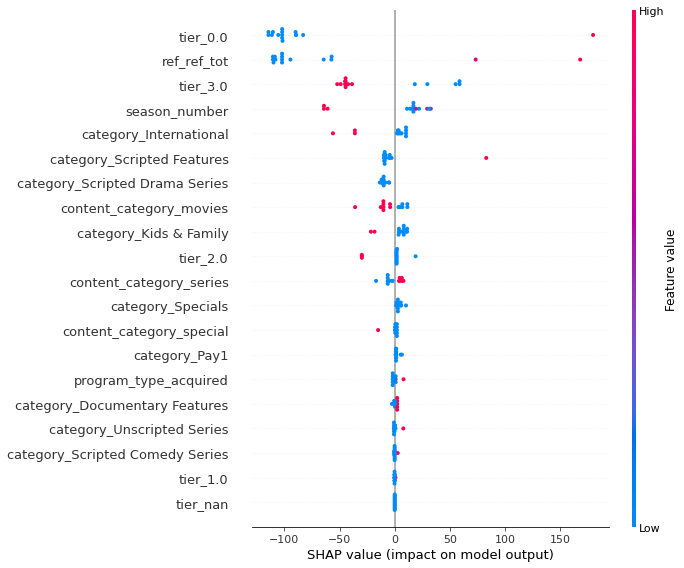

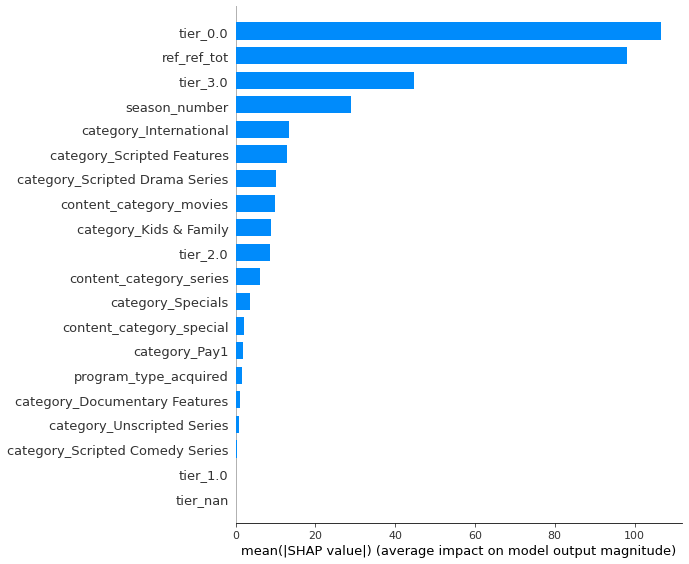

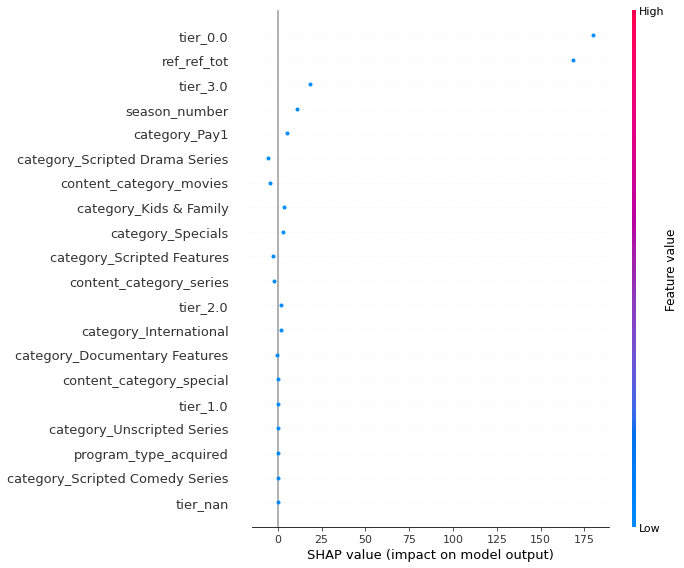

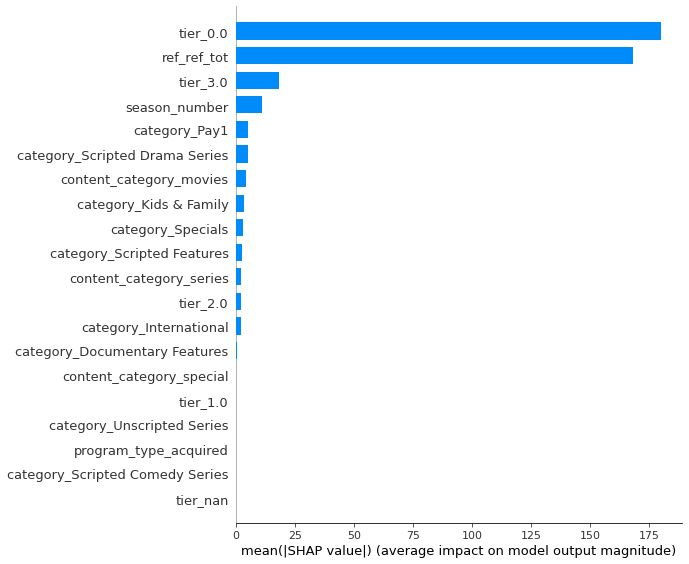

,category,start_year,title_name,tier,season_number,title_id,content_category,ref_ref_tot,first_views,program_type,first_views_log_dev_b,first_views_dev_b
3,Popcorn,2021,Godzilla vs. Kong,0,0,GYFEzmwNES16GkQEAAAAC,movies,164.0,2017162,acquired,820.705078,2.291026e+06
10,Scripted Features,2021,Zack Snyder's Justice League,1,0,GYDAnZgCFQ8IJpQEAAAAN,movies,69.0,1154956,original,595.678040,3.934200e+05
28,Documentary Features,2021,Tina,2,0,GYB2e7gq3xivCIgEAAAAb,movies,0.0,31807,original,338.881989,2.916202e+04
66,Docu-Series,2021,Q: Into the Storm,2,1,GYDk9Ig48c5i6hgEAAAA7,series,0.0,32222,original,381.158752,4.784024e+04
300,Scripted Comedy Series,2021,Genera+ion,2,1,GYCb8twFvgMNNUAEAAAA1,series,0.0,16736,original,381.158752,4.784024e+04
328,Documentary Features,2021,Covid Diaries NYC,3,0,GYBlp3g0gpJmNkAEAAAAC,movies,0.0,1560,original,200.213226,4.142611e+03
337,Documentary Features,2021,Persona: The Dark Truth Behind Personality Tests,3,0,GYC1puQhu1cLCwgEAAAA0,movies,0.0,7850,original,200.213226,4.142611e+03
343,Documentary Features,2021,The Day Sports Stood Still,3,0,GYB3A4QcDM8LDAgEAAABX,movies,0.0,1362,original,200.213226,4.142611e+03
344,Documentary Features,2021,The Last Cruise,3,0,GYEJfggAmqTO8jwEAAAAC,movies,0.0,7333,original,200.213226,4.142611e+03
361,International,2021,The Garden of Evening Mists,3,0,GYEqQ7wi3xJ2evQEAAAAI,movies,0.0,153,acquired,84.204514,3.614978e+02


In [566]:
import shap
def get_shap(df_pred, model, ohe, features, value=0):
    """
    ev, shap, x_ohe = get_shap(df_pred, 'pop', model_path, 'return')
    shap.force_plot(ev, shap, x_ohe)
    """
    df_x = df_pred[features]

    shap.initjs()
    x_ohe = ohe.transform(df_x)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_ohe)
    
    shap.summary_plot(shap_values, x_ohe)
    shap.summary_plot(shap_values, x_ohe, plot_type="bar")
    return explainer.expected_value, shap_values[value,:], x_ohe.iloc[value,:]

## xgb w/ clean data  
features_cont_dev=[
    'season_number',
    'ref_ref_tot',
]


df_pred_list = []
for date_pred in ['2021-03-01']:
    df_train_in = df[(df.effective_start_date < datetime.strptime(date_pred, '%Y-%m-%d')- timedelta(days=60))]
    target_count = df_train_in[df_train_in.tier==3].shape[0]
    df_train_in_tierp = df_train_in[(df_train_in.category=='Popcorn')].sample(target_count, replace=True)
    df_train_in_tier0 = df_train_in[(df_train_in.tier!=3) & (df_train_in.category!='Popcorn')].sample(target_count, replace=True)
    df_train_in_tier3 = df_train_in[df_train_in.tier==3]
    df_train_in = pd.concat([df_train_in_tierp, df_train_in_tier0, df_train_in_tier3], axis=0)

    display(df_train_in[df_train_in['category']=='Popcorn'])
    df_train_in['first_views_log'] = np.log(df_train_in['first_views'])**2.5
    model, ohe = train_xgb(df_train_in, features_cat, features_cont_dev, target, param_xgb)
#         display(df_train_in[df_train_in.category=='Popcorn'])

    df_test = df[df.effective_start_date.dt.strftime('%Y-%m')== datetime.strptime(date_pred, '%Y-%m-%d').strftime('%Y-%m')]
    df_pred = predict_xgb(df_test, model, ohe, features_cat, features_cont_dev, target, postfix)
    df_pred[f'first_views_{postfix}'] = np.exp(df_pred[f'first_views_log_{postfix}']**(1/2.5))

ev, shap_values, x_ohe = get_shap(df_test, model, ohe, features_cat + features_cont_dev)

ev, shap_values, x_ohe = get_shap(df_test[df_test.title_name.str.contains('Godzilla')], model, ohe, features_cat + features_cont_dev)
shap.force_plot(ev, shap_values, x_ohe)
display(df_pred)

In [434]:
df[df.category=='Popcorn'].sort_values(by='effective_start_date')

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,asset_title_long,imdb_id,genres,title_type,ref_follows,ref_remake_of,ref_spin_off_from,ref_ref_featured_in,ref_ref_spoofed_in,ref_tot,ref_ref_tot
7,0,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,Wonder Woman 1984,tt7126948,"[""Action"",""Adventure"",""Fantasy""]",movie,1.0,0.0,0.0,83.0,6.0,1.0,89.0
46,1,movies,Popcorn,The Little Things,GYA79hQZbUsI3gQEAAAB0,0,acquired,2021-01-29,635584,2.130,2021,1,2021-01,1,13.362300,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,1,movies,Popcorn,Judas and the Black Messiah,GYBmsKA4FaUnDdQEAAAAj,0,acquired,2021-02-12,319734,2.091,2021,2,2021-02,1,12.675245,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50,1,movies,Popcorn,Tom & Jerry,GYEb9QwLgFF9_ZwEAAAA7,0,acquired,2021-02-26,595699,1.684,2021,2,2021-02,1,13.297491,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,movies,Popcorn,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,0,acquired,2021-03-31,2017162,1.886,2021,3,2021-03,1,14.517202,Godzilla vs. Kong,tt5034838,"[""Action"",""Sci-Fi"",""Thriller""]",movie,3.0,2.0,0.0,146.0,18.0,5.0,164.0
5,0,movies,Popcorn,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,0,acquired,2021-04-23,1074951,1.834,2021,4,2021-04,2,13.887786,Mortal Kombat,tt0293429,"[""Action"",""Adventure"",""Fantasy"",""Sci-Fi"",""Thri...",movie,0.0,1.0,1.0,176.0,62.0,2.0,238.0
48,1,movies,Popcorn,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,0,acquired,2021-05-14,153249,1.661,2021,5,2021-05,2,11.939819,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45,1,movies,Popcorn,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,0,acquired,2021-06-04,571005,1.864,2021,6,2021-06,2,13.255153,The Conjuring: The Devil Made Me Do It,tt7069210,"[""Horror"",""Mystery"",""Thriller""]",movie,2.0,0.0,0.0,81.0,5.0,2.0,86.0
42,1,movies,Popcorn,In The Heights,GYK0x7gXCza4OwwEAAADl,0,acquired,2021-06-10,195239,2.383,2021,6,2021-06,2,12.181980,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [176]:
df_train_in[(df_train_in.content_category=='movies') & (df_train_in.category!='Popcorn')]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,tier_new
0,1,movies,Pay1,Tenet,GYEq4eApHYpA4cwEAAAAC,0,acquired,2021-05-02,43052,2.502,2021,5,2021-05,2,10.670164,1
1,1,movies,Pay1,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2021-05-13,70732,0.000,2021,5,2021-05,2,11.166653,1
6,1,movies,Scripted Features,Roald Dahl’s The Witches,GX5A8JQnSPQ2QFgEAAAAC,0,original,2020-10-22,524524,1.737,2020,10,2020-10,4,13.170246,1
7,1,movies,Scripted Features,Zack Snyder's Justice League,GYDAnZgCFQ8IJpQEAAAAN,0,original,2021-03-18,1154956,4.036,2021,3,2021-03,1,13.959573,1
22,2,movies,Documentary Features,The Bee Gees: How Can You Mend A Broken Heart,GX5lfBgOJ7RKRwgEAAAMG,0,original,2020-12-13,49718,1.846,2020,12,2020-12,4,10.814122,2
23,2,movies,Documentary Features,Tina,GYB2e7gq3xivCIgEAAAAb,0,original,2021-03-28,31807,1.962,2021,3,2021-03,1,10.367442,2
24,2,movies,Pay1,Ad Astra,GXo-RygZTqQwlRQEAAAAE,0,acquired,2020-06-07,53772,2.053,2020,6,2020-06,2,10.892508,2
25,2,movies,Pay1,Birds of Prey: Harley Quinn,GXtq0PQyT7MPCwgEAAAaq,0,acquired,2020-08-16,81001,1.814,2020,8,2020-08,3,11.302217,2
26,2,movies,Pay1,Dolittle,GX1oycwoNEsMslAEAAAAI,0,acquired,2020-11-15,37655,1.691,2020,11,2020-11,4,10.536221,2
27,2,movies,Pay1,Ford v Ferrari,GXpTQQAAyyAwlRQEAABgA,0,acquired,2020-06-21,65753,2.548,2020,6,2020-06,2,11.093661,2


In [173]:
df_train_in[(df_train_in.category=='Popcorn')]

,tier,content_category,category,title_name,title_id,season_number,program_type,effective_start_date,first_views,premiering_hours_runtime,start_year,start_month,start_year_month,start_quarter,first_views_log,tier_new
3,1,movies,Popcorn,Godzilla vs. Kong,GYFEzmwNES16GkQEAAAAC,0,acquired,2021-03-31,2017162,1.886,2021,3,2021-03,1,14.517202,0
4,1,movies,Popcorn,Mortal Kombat,GYGYKfQwaKLheqwEAAAEC,0,acquired,2021-04-23,1074951,1.834,2021,4,2021-04,2,13.887786,0
5,1,movies,Popcorn,Wonder Woman 1984,GX9KHPw1OIMPCJgEAAAAD,0,acquired,2020-12-25,2727097,2.484,2020,12,2020-12,4,14.818748,0
36,2,movies,Popcorn,Judas and the Black Messiah,GYBmsKA4FaUnDdQEAAAAj,0,acquired,2021-02-12,319734,2.091,2021,2,2021-02,1,12.675245,1
38,2,movies,Popcorn,The Little Things,GYA79hQZbUsI3gQEAAAB0,0,acquired,2021-01-29,635584,2.130,2021,1,2021-01,1,13.362300,1
39,2,movies,Popcorn,Those Who Wish Me Dead,GYH8W5wtYpsPDwgEAAAAC,0,acquired,2021-05-14,153249,1.661,2021,5,2021-05,2,11.939819,1
40,2,movies,Popcorn,Tom & Jerry,GYEb9QwLgFF9_ZwEAAAA7,0,acquired,2021-02-26,595699,1.684,2021,2,2021-02,1,13.297491,1


In [196]:
df_pred['diff'] = (df_pred['first_views_dev']-df_pred['first_views']).abs()
df_pred.sort_values(by='diff', ascending=False)

,title_name,title_id,start_year,tier_new,content_category,program_type,category,season_number,first_views,first_views_dev,diff
37,The Conjuring: The Devil Made Me Do It,GYLEE7gB0zcLCwgEAAAHj,2021,1,movies,acquired,Popcorn,0,571005,243620.062500,327384.937500
35,In The Heights,GYK0x7gXCza4OwwEAAADl,2021,1,movies,acquired,Popcorn,0,195239,243620.062500,48381.062500
44,No Sudden Move,GYMzEGg049ruJvQEAAAAW,2021,2,movies,acquired,Scripted Features,0,49858,26571.292969,23286.707031
29,Judas and the Black Messiah,GYBmsKA4FaUnDdQEAAAAj,2021,2,movies,acquired,Pay1,0,10683,28035.773438,17352.773438
34,The Little Things,GYA79hQZbUsI3gQEAAAB0,2021,2,movies,acquired,Pay1,0,38699,28035.773438,10663.226562
142,Fatale,GYHmDAQRp2grCFgEAAAAC,2021,3,movies,acquired,Pay1,0,14697,5685.003418,9011.996582
73,Tom & Jerry in New York,GYMDm0AJXAH0LrgEAAAAF,2021,2,series,original,Kids & Family,1,5113,10089.482422,4976.482422
246,All That Glitters,GYNHTDQuvpMLCewEAAAAG,2021,3,series,original,Unscripted Series,1,1609,5323.430176,3714.430176
147,Kajillionaire,GYIHBbgg_NZ2TjQEAAADx,2021,3,movies,acquired,Pay1,0,2456,5685.003418,3229.003418
133,Juan Luis Guerra 4.40: Entre Mar y Palmeras,GYJ1S5Qt5TG2gdAEAAABv,2021,3,movies,original,International,0,2695,153.333191,2541.666809
